In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import anndata
import scipy.stats

import re
import os
import tarfile
import scanpy as sc
import seaborn as sns
import umap
import sklearn.cluster
import h5py

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

In [2]:
from matplotlib.colors import LinearSegmentedColormap
values = [0,1]
colors = [(227, 227, 227), (255, 42, 18)]
norm = plt.Normalize(min(values), max(values))
my_cmap = LinearSegmentedColormap.from_list(
    '', [(norm(value), tuple(np.array(color) / 255)) for value, color in zip(values, colors)])
my_cmap.set_bad(color='#E3E3E3')

In [3]:
adata = sc.read_h5ad('F:/Transwell/final_fetal_object_cellxgene.h5ad')

In [4]:
set(adata.obs['cell_name_detailed'])

{'Arterial endothelial cell',
 'BEST4+ enterocyte',
 'Colonocytes',
 'Early enterocyte',
 'Enteric neurons',
 'Enterocyte',
 'Enterocytes',
 'Enteroendocrine',
 'Erythroblasts',
 'FOXL1+ fibroblasts',
 'FRZB+ fibroblasts',
 'G2M/S enterocytes',
 'Goblet',
 'Immune cells',
 'Interstitial cells of Cajal',
 'LGR5 stem',
 'Lymphatic endothelial cell',
 'Mesoderm 1',
 'Mesoderm 2',
 'Myofibroblast',
 'NTS+ epithelial cells',
 'Neural crest cells',
 'Pericyte',
 'Serosa/mesothelial cells',
 'Smooth muscle cells',
 'Uniform progenitors',
 'Venous endothelial cell',
 'WNT4+ fibroblasts'}

In [11]:
our_names =  ['LGR5 stem','Goblet','Enteroendocrine']

In [20]:
TW_DE = pd.read_csv('TW_DE_reordered.csv',index_col = 0)

In [11]:
import pickle
with open('F:/Transwell/TW_id_group.pkl', 'rb') as file:
    # Load the data from the file
    loaded_variable = pickle.load(file)

In [22]:
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib
matplotlib.rc_file_defaults()
plt.close()
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
names = ['ISC','Goblet','EEC']
#define the important gene that audience might interested
imp_genes = dict()
imp_genes['ISC'] = ['LGR5', 'ASCL2','SMOC2','MSI1','OLFM4']
imp_genes['Goblet'] = ['MUC2','MUC5AC','FCGBP','SOX4','SPDEF', 'FCGBP','TFF3']
imp_genes['EEC'] = ['CHGA','CHGGB','INSM1','PAX4','PAX6']


plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 11, 'font.weight': 'heavy','axes.linewidth':2})
TW_names = ['ISC','Goblet','EEC']
adata_df = pd.DataFrame(adata.X.A)
adata_df.index = adata.obs_names
adata_df.columns = adata.var_names
adata_df['cell_name_detailed'] = adata.obs['cell_name_detailed']

color = np.array(adata_df['cell_name_detailed'].values.ravel())
for j in range(0, len(color)):
    id = np.where(adata.obs['cell_name_detailed'].cat.categories == color[j])[0][0]
    color[j]=adata.uns['cell_name_detailed_colors'][id]
adata_df['color'] = color

TW_gene_reordered = dict()

def cluster_cols(data):
    Z = linkage(data.T, method='average')  # Note the transpose (.T) to cluster columns
    order = leaves_list(Z)
    return data.iloc[:, order]

In [24]:
for i in range(0, len(TW_names)):
    # Create the combined list
    TW_DE_list = TW_DE[TW_names[i]].dropna()
    adata_df[TW_DE_list[~TW_DE_list.isin(adata_df.columns)].tolist()] = np.zeros([adata_df.shape[0], len(TW_DE_list[~TW_DE_list.isin(adata_df.columns)].tolist())])

    # Slice data for clustering
    adata_slice = adata_df.loc[adata_df['cell_name_detailed'] == our_names[i], :]
    adata_slice = adata_slice.sort_values(by='cell_name_detailed')
    
    col_colors = adata_slice['color'].tolist()
    
    adata_slice_clustered = adata_slice[TW_DE_list]
    
    ribo_gene_mask = [gene.startswith('RPL') or gene.startswith('RPS') for gene in adata_slice_clustered.columns]
    adata_slice_clustered = adata_slice_clustered.loc[:,np.array(ribo_gene_mask)==False]
    
    TW_gene_reordered[names[i]] = adata_slice_clustered.columns
    print(adata_slice_clustered.columns)
    # Plot the clustered heatmap
    clustergrid = sns.clustermap(adata_slice_clustered.T, figsize=(5, len(TW_DE_list)/5), linewidths=0,
                                 colors_ratio=(0.05, 0.05), yticklabels=True, xticklabels=False, cmap=my_cmap, 
                                 col_colors=col_colors,
                                 col_cluster=False, row_cluster=False, standard_scale=0,
                                 cbar_kws={'label': '', 'location': "left"})

    # Adjustments for the plot
    for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(2)
    clustergrid.ax_cbar.set_position([0, 0.2, 0.03, 0.3])

    axs = clustergrid.fig.get_axes()
    for ax in axs:
        ax.set_xlabel('')
    for lab in axs[3].get_yticklabels():
        text = lab.get_text()
        if text in imp_genes[names[i]]:
            lab.set_weight('bold')
            lab.set_color('red')

    # Save the plot
    #plt.show()
    plt.savefig('F:/Transwell/'+our_names[i] + '_TW_signature_in_fetal.png', dpi=300, bbox_inches='tight')
    

Index(['SPINK1', 'TFF3', 'SMOC2', 'PLA2G2A', 'SI', 'SORBS2', 'PROX1', 'ADH6',
       'DLL1', 'SERPINF1', 'OLFML3', 'IGDCC3', 'NR2F1', 'FGG', 'TNFRSF19'],
      dtype='object', name='index')
Index(['TFF3', 'FCGBP', 'MUC2', 'TMSB4X', 'NEAT1', 'WFDC2', 'LINC00261',
       'GMDS', 'SELENOM', 'HES6',
       ...
       'NPDC1', 'GSN', 'BCAS1', 'XBP1', 'SMIM22', 'CDC42EP5', 'SH3BGRL3',
       'SLC12A2', 'LGALS4', 'S100A6'],
      dtype='object', name='index', length=107)
Index(['PCSK1N', 'MDK', 'SOX4', 'KCTD12', 'CDKN1C', 'RGS2', 'HEPACAM2',
       'INSM1', 'EID1', 'RASD1', 'HES6', 'BTG2', 'RAB3B', 'RBP1', 'SSTR2',
       'TP53I3', 'RAMP1', 'DEPP1', 'DPEP1', 'DNAJC12', 'ANXA13', 'BAZ2B',
       'CXXC4', 'GADD45G', 'PAX4', 'IL13RA1', 'PROX1', 'TP53INP1', 'TPCN1',
       'CBFA2T2', 'NEURL1', 'ARHGAP32', 'KLK12', 'FOXA2', 'LINC00261', 'ADI1',
       'FAM210B', 'SLC25A29', 'NAIP', 'PCBP4', 'CLPS', 'CCDC112', 'FAM241B',
       'FGD4', 'MCF2L', 'CFAP65', 'CDKAL1', 'NREP', 'DBN1', 'CDC42EP3',
      

In [5]:
def DE_to_df(_adata, rank_key, _padj_thresh=0.05, _logfc_thresh=1):
    def process_genes(i, direction):
        _log2foldmask = (_adata.uns[rank_key]['logfoldchanges'][i].astype('double') >= _logfc_thresh) if direction == "up" else (_adata.uns[rank_key]['logfoldchanges'][i].astype('double') <= -_logfc_thresh)
        _pvalmask = _adata.uns[rank_key]['pvals_adj'][i].astype('double') <= _padj_thresh
        _additional = pd.DataFrame({
            i: _adata.uns[rank_key]['names'][i].astype('str')[_log2foldmask & _pvalmask],
            'logfoldchanges_'+i: np.abs(_adata.uns[rank_key]['logfoldchanges'][i].astype('double')[_log2foldmask & _pvalmask])
        })
        _ribo_gene_mask = [gene.startswith('RPL') or gene.startswith('RPS') for gene in _additional[i]]
        _mt_gene_mask = [gene.startswith('MT-') for gene in _additional[i]]
        if len(_ribo_gene_mask)>0 and len(_mt_gene_mask)>0:
            _drop_id = np.array(np.array(_ribo_gene_mask) | np.array(_mt_gene_mask))
            _additional = _additional.sort_values(by='logfoldchanges_'+i, ascending=False)
            _additional = _additional.iloc[_drop_id==False, :].reset_index(drop=True)
        return _additional
    _pass_genes_up = pd.DataFrame()
    _pass_genes_down = pd.DataFrame()
    for i in set(_adata.uns[rank_key]['pvals_adj'].dtype.names):
        _pass_genes_up = pd.concat([_pass_genes_up, process_genes(i, "up")[i]], ignore_index=False, axis=1)
        _pass_genes_down = pd.concat([_pass_genes_down, process_genes(i, "down")[i]], ignore_index=False, axis=1)
    return _pass_genes_up, _pass_genes_down

In [22]:
adata_epi = adata[adata.obs['cell_name_detailed'].isin(['BEST4+ enterocyte', 'Goblet', 'LGR5 stem', 'Colonocytes',
       'Uniform progenitors', 'Enterocytes',
       'G2M/S enterocytes', 'Early enterocyte', 'Enterocyte',
       'Enteroendocrine', 'NTS+ epithelial cells']),:]

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\anndata\_core\anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [23]:
sc.tl.rank_genes_groups(adata_epi, groupby='cell_name_detailed', key_added='rank',method = 'wilcoxon')

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [34]:
[pass_genes_up, pass_genes_down] = DE_to_df(adata_epi, rank_key='rank', _padj_thresh = 0.01, _logfc_thresh = 2)

In [35]:
pass_genes_up[['LGR5 stem', 'Goblet','Enteroendocrine']].to_csv('fetal_DE.csv')

In [36]:
absb = dict()
absb['Fatty Acid']=['SLC27A4', 'CD36', 'FABP1', 'FABP2', 'FABP6', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'PCK1', 'PCK2', 'PDK4', 'MTTP', 'DGAT1', 'ASCL5']
absb['Glucose']=['SLC5A1', 'SLC2A2','SLC2A3', 'SLC2A5', 'SLC2A9', 'SLC2A10', 'SLC5A1', 'SLC5A9'] # SLC5A4
absb['Cholestrol']=['ABCG8', 'NPC1L1', 'SCARB1']
absb['Enzyme']=['MGAM', 'SI', 'LCT', 'ANPEP', 'ENPEP', 'DPP4', 'ALPI','CA1','CA2']
absb['Amino Acid']=['SLC15A1', 'SLC6A19', 'SLC6A20', 'PATL1', 'SLC25A15', 'SLC7A8', 'SLC3A1', 'SLC3A2', 'SLC6A6', 'SLC7A7', 'SLC1A5', 'SLC38A1']
absb['Cation']=['SLC22A1', 'SLC22A2', 'SLC22A3', 'SLC22A4', 'SLC22A5', 'SLCO2B1']
absb['Ion']=['SLC25A3', 'SLC26A2','SLC26A3', 'SLC4A7']
absb['Bile'] = ['SLC10A1','SLC10A2','SLCO1A2']
absb['Vitamin']=['RBP2', 'RBP4', 'TCN2', 'CYP4F2', 'CD320']
absb['Water']=['AQP1', 'AQP3', 'AQP7', 'AQP8', 'AQP10', 'AQP11']
absb['Proliferative'] = ['MKI67','TOP2A']

In [37]:
import anndata
sig_list = []
for k,v in absb.items():
    sig_list+=v

missing_genes = pd.Series(sig_list)[pd.Series(sig_list).isin(adata.var_names)==False]
new_variables_data = np.zeros((adata.n_obs, len(missing_genes)))
adata_forvis = anndata.AnnData(X=np.hstack([adata.X.A, new_variables_data]),
                        obs=adata.obs,
                        var=pd.DataFrame(index=list(adata.var.index) +list( missing_genes)))

C:\Users\16220\AppData\Local\Temp\ipykernel_4624\2264752638.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_forvis = anndata.AnnData(X=np.hstack([adata.X.A, new_variables_data]),


In [71]:
adata_forvis.obs['cell_name_detailed'].cat.categories

Index(['Arterial endothelial cell', 'BEST4+ enterocyte', 'Enteric neurons',
       'Erythroblasts', 'FOXL1+ fibroblasts', 'FRZB+ fibroblasts', 'Goblet',
       'Interstitial cells of Cajal', 'LGR5 stem', 'Colonocytes',
       'Lymphatic endothelial cell', 'Neural crest cells',
       'Uniform progenitors', 'Enterocytes', 'Smooth muscle cells',
       'Serosa/mesothelial cells', 'Venous endothelial cell',
       'WNT4+ fibroblasts', 'G2M/S enterocytes', 'Early enterocyte',
       'Enterocyte', 'Enteroendocrine', 'NTS+ epithelial cells',
       'Immune cells', 'Mesoderm 1', 'Mesoderm 2', 'Myofibroblast',
       'Pericyte'],
      dtype='object')

In [72]:
adata_EC = adata_forvis[adata_forvis.obs['cell_name_detailed'].isin(['G2M/S enterocytes', 'Early enterocyte','Colonocytes','Enterocyte']),:]

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\anndata\_core\anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


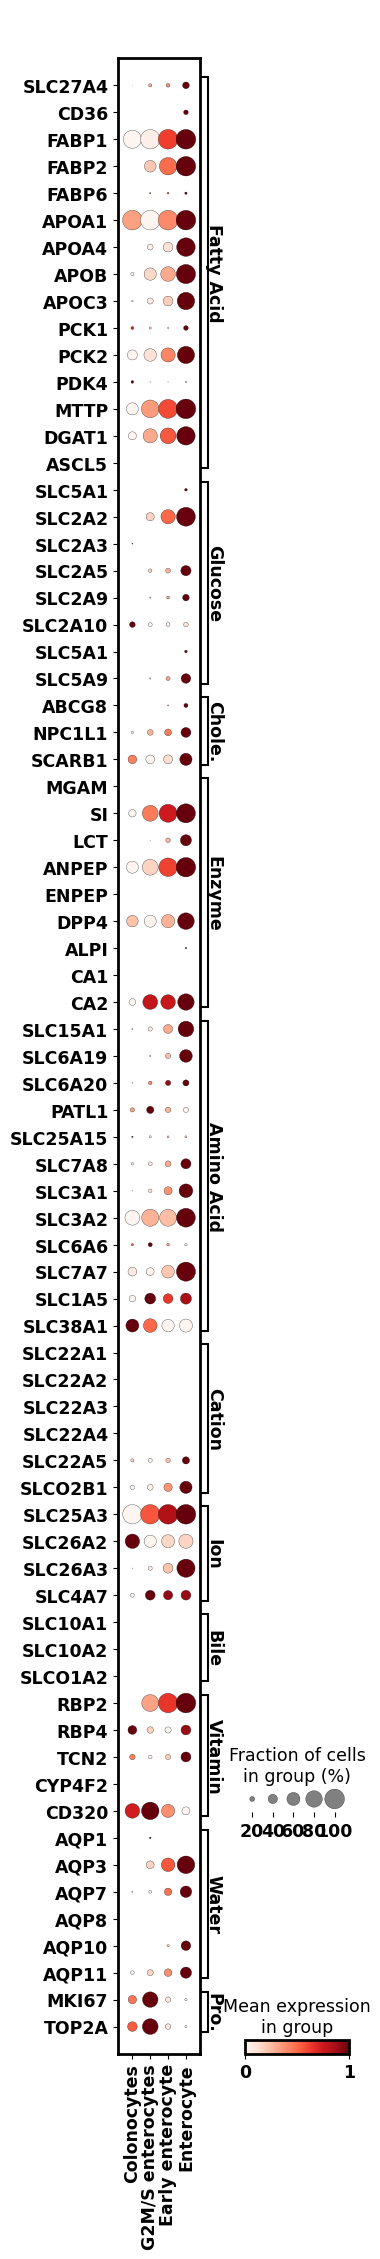

In [74]:
#matplotlib.rc_file_defaults()
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2}),
sc.pl.dotplot(adata_EC,
              absb, 'cell_name_detailed',vmax =1, swap_axes = True, dot_min = 0.05, standard_scale='var',save = 'id_fetal_ec.png')

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


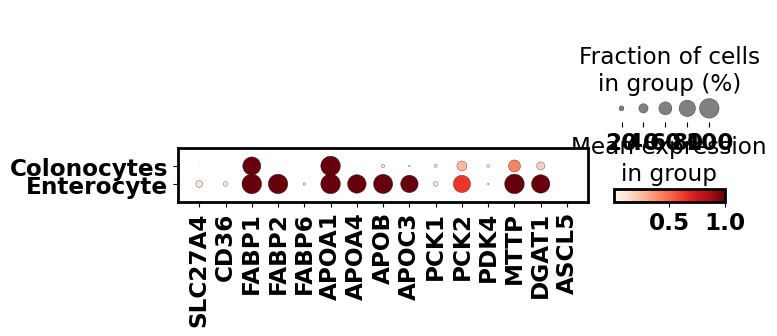

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


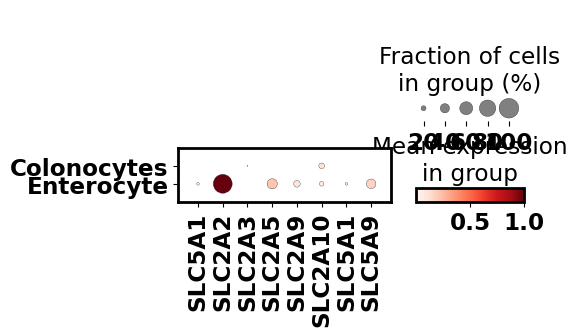

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


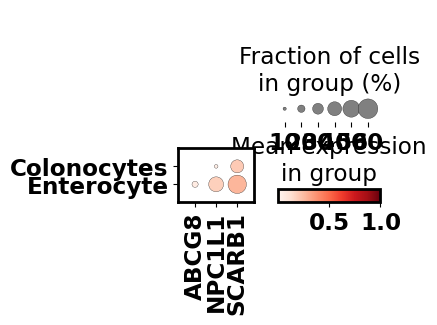

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


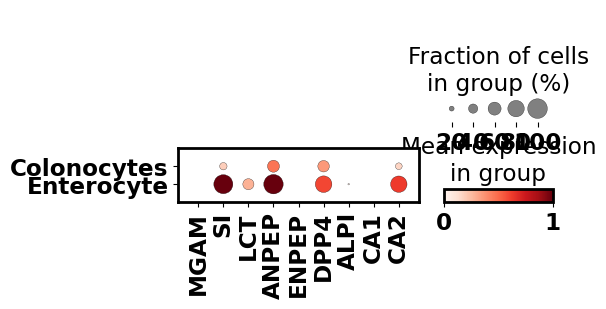

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


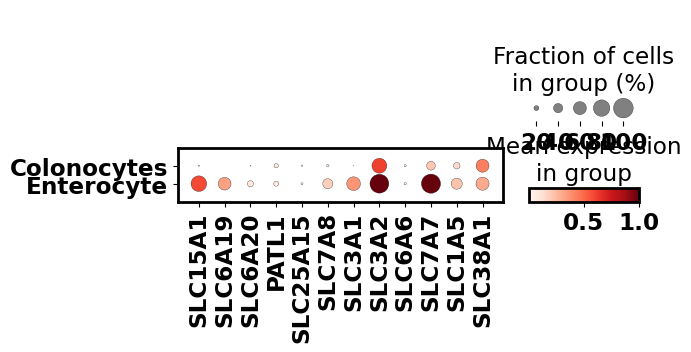

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


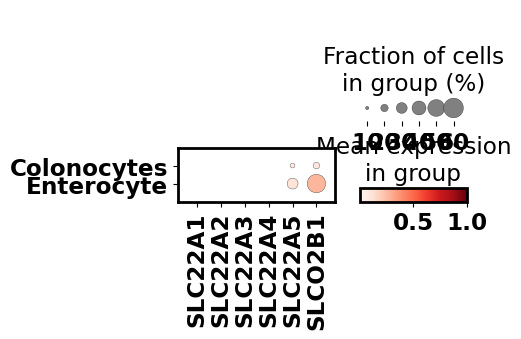

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


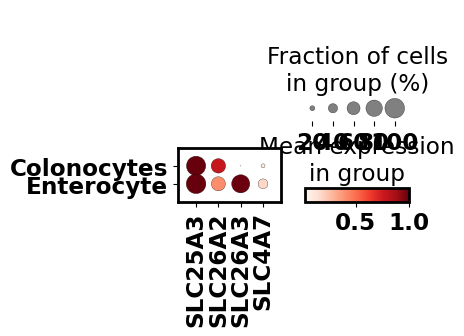

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


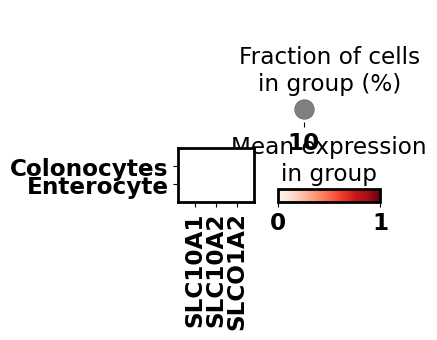

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


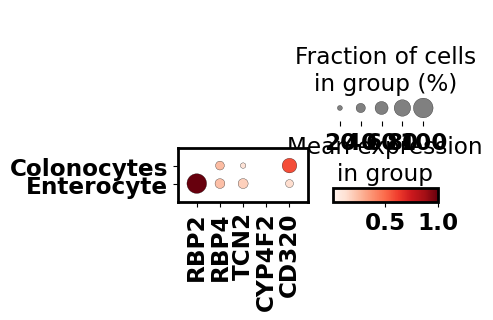

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


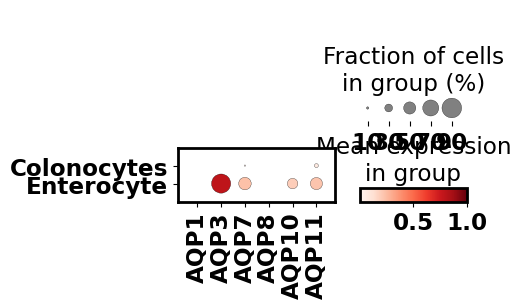

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


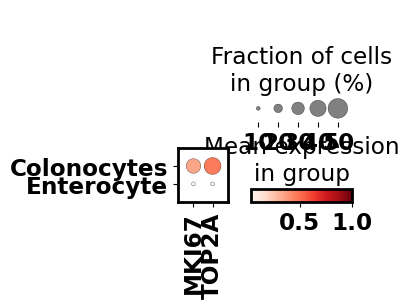

In [55]:
import matplotlib
#matplotlib.rc_file_defaults()
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold','axes.linewidth':2})
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold','axes.linewidth':2})
for i in absb.keys():
    sc.pl.dotplot(adata_EC,
              absb[i], 'cell_name_detailed', vmax =1, swap_axes = False, dot_min = 0.05,  save = i+'_fetal.png'
              )

In [40]:
adata.obs['cell_name_detailed'].cat.categories

Index(['Arterial endothelial cell', 'BEST4+ enterocyte', 'Enteric neurons',
       'Erythroblasts', 'FOXL1+ fibroblasts', 'FRZB+ fibroblasts', 'Goblet',
       'Interstitial cells of Cajal', 'LGR5 stem', 'Colonocytes',
       'Lymphatic endothelial cell', 'Neural crest cells',
       'Uniform progenitors', 'Enterocytes', 'Smooth muscle cells',
       'Serosa/mesothelial cells', 'Venous endothelial cell',
       'WNT4+ fibroblasts', 'G2M/S enterocytes', 'Early enterocyte',
       'Enterocyte', 'Enteroendocrine', 'NTS+ epithelial cells',
       'Immune cells', 'Mesoderm 1', 'Mesoderm 2', 'Myofibroblast',
       'Pericyte'],
      dtype='object')

In [56]:
our_names =  ['LGR5 stem', 'Gobelt','Enteroendocrine']
fetal_common_genes=dict()
for i in our_names:
    adata_temp = adata[adata.obs['cell_name_detailed'] == i, :]
    sc.pp.filter_genes(adata_temp, min_cells = np.ceil(adata_temp.shape[0]*0.3))
    fetal_common_genes[i] = adata_temp.var_names
fetal_common_genes = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in fetal_common_genes.items() ]))
fetal_common_genes.to_csv('fetal_common_genes.csv')

C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\anndata\_core\anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\16220\anaconda3\envs\cpdb\lib\contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future 

In [53]:
TW_common_genes = pd.read_csv('TW_common_genes.csv',index_col = 0)

In [69]:
fetal_common_genes

,LGR5 stem,Gobelt,Enteroendocrine
0,FO538757.2,RP11-34P13.7,FO538757.2
1,NOC2L,RP11-34P13.8,AP006222.2
2,AGRN,FO538757.3,NOC2L
3,SDF4,FO538757.2,SDF4
4,UBE2J2,AP006222.2,UBE2J2
...,...,...,...
26752,NaN,AC007325.4,NaN
26753,NaN,AC007325.2,NaN
26754,NaN,AL354822.1,NaN
26755,NaN,AC004556.1,NaN


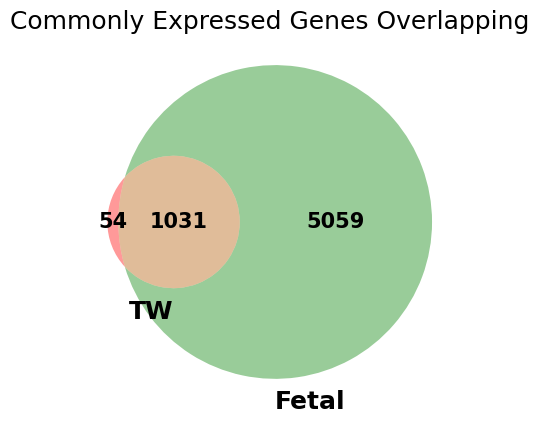

In [70]:
from matplotlib_venn import venn2
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
names = ['Intestinal Stem like (ISCLC)',
             'Goblet like (GCLC)',
             'Enteroendocrine like (EECLC)']
for i in range(0,len(names)):
    plt.close()
    set1 = set(TW_common_genes[names[i]].dropna())
    set2 = set(fetal_common_genes.iloc[:,i].dropna())
    venn2([set1, set2], ('TW', 'Fetal'))
    plt.title("Commonly Expressed Genes Overlapping".format(i))
    plt.savefig(names[i]+'fetal_commonly_expressed_venn.png', dpi=300, bbox_inches='tight')